# Bitcoin Utilities API Demo

This notebook demonstrates how to use the API functions provided in `bitcoin_utils.py`. It shows minimal working examples of:

- Loading and cleaning data.
- Updating the dataset with the latest data point from CoinGecko.
- Adding technical features.
- Generating LSTM-ready sequences.

This notebook focuses on **API usage only** (no model training or deep EDA).

See: `tensorflow.API.md` for detailed explanations.


References:
- [Causify API Tutorial Guide](https://github.com/causify-ai/helpers/blob/master/docs/coding/all.jupyter_notebook.how_to_guide.md)
- `bitcoin_utils.py`

---

In [7]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

# Imports
import sys
sys.path.append("..")  # if needed to import bitcoin_utils.py

import numpy as np
import matplotlib.pyplot as plt

from bitcoin_utils import (
    load_and_clean_csv,
    update_dataset_with_latest,
    technical_features,
    generate_sequences,
    build_lstm_model,
    train_lstm_model,
    fine_tune_model,
    plot_training_loss,
    predict_next_price
)


## Step 1: Load and Clean Dataset

We load the Bitcoin dataset and clean it using the `load_and_clean_csv()` function.


In [8]:
# Path to the CSV
csv_path = 'btc-usd-max.csv'

# Load and clean
df = load_and_clean_csv(csv_path, remove_anomalies=True)

# Show the first few rows
df.head()


INFO:bitcoin_utils:Loading dataset from btc-usd-max.csv
INFO:bitcoin_utils:Removed 100 anomalous rows based on z-score > 3.0
INFO:bitcoin_utils:Dataset loaded: 4306 rows; columns: ['price', 'market_cap', 'total_volume']


,price,market_cap,total_volume
snapped_at,,,
2013-04-28 00:00:00+00:00,135.30,1.500518e+09,0.0
2013-04-29 00:00:00+00:00,141.96,1.575032e+09,0.0
2013-04-30 00:00:00+00:00,135.30,1.501657e+09,0.0
2013-05-01 00:00:00+00:00,117.00,1.298952e+09,0.0
2013-05-02 00:00:00+00:00,103.43,1.148668e+09,0.0


## Step 2: Update Dataset with Latest Price from CoinGecko

We fetch the latest Bitcoin data from CoinGecko and update the existing dataset using the `update_dataset_with_latest()` function.


In [9]:
# Update the dataset (this will fetch the latest data and append if needed)
update_dataset_with_latest(csv_path)

INFO:bitcoin_utils:Loading existing dataset from btc-usd-max.csv
INFO:bitcoin_utils:Fetching latest data point from CoinGecko
INFO:bitcoin_utils:Latest data point: {'snapped_at': Timestamp('2025-05-18 03:59:34+0000', tz='UTC'), 'price': 103310.65086309676, 'market_cap': 2052290327956.2463, 'total_volume': 16471648100.15313}
INFO:bitcoin_utils:Appending new data point to the dataset.
INFO:bitcoin_utils:Dataset updated and saved to btc-usd-max.csv


## Step 3: Feature Engineering

We apply `technical_features()` to enrich the DataFrame with engineered columns.


In [10]:
# Add engineered features
df = technical_features(df)
features = [
    'price', 'returns', 'SMA_7', 'SMA_30', 'volatility_7', 'volatility_30',
    'lag_1day', 'RSI_14', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower'
]
X, y, scaler_X, scaler_y = generate_sequences(df, features=features, target='price', window_size=60)


# Now safely generate sequences


print("X shape:", X.shape)
print("y shape:", y.shape)
print("Any NaN in X?", np.isnan(X).any())
print("Any NaN in y?", np.isnan(y).any())
print("X min/max:", X.min(), X.max())
print("y min/max:", y.min(), y.max())


# Drop rows with NaNs in any input feature or the target
df = df.dropna(subset=features + ['price'])
# Check the result
df.tail()

INFO:bitcoin_utils:Adding extended technical features...
INFO:bitcoin_utils:Technical feature engineering complete.
INFO:bitcoin_utils:Generating sequences using features ['price', 'returns', 'SMA_7', 'SMA_30', 'volatility_7', 'volatility_30', 'lag_1day', 'RSI_14', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower'] and target 'price'
INFO:bitcoin_utils:Generated 4246 sequences with shape (60, 12)


X shape: (4246, 60, 12)
y shape: (4246, 1)
Any NaN in X? True
Any NaN in y? False
X min/max: nan nan
y min/max: 0.0 1.0


,price,market_cap,total_volume,returns,SMA_7,SMA_30,volatility_7,volatility_30,lag_1day,RSI_14,MACD,MACD_signal,BB_upper,BB_lower
snapped_at,,,,,,,,,,,,,,
2025-04-27 00:00:00+00:00,94644.066371,1.879132e+12,1.544539e+10,-0.001362,91856.689034,84944.749173,3910.916209,4735.202649,94773.112006,79.477496,2738.278784,1455.085103,96779.780057,75204.818407
2025-04-28 00:00:00+00:00,93809.337820,1.862772e+12,1.592626e+10,-0.008820,93104.713659,85259.744795,2538.545528,5001.737256,94644.066371,84.093632,2839.206967,1731.909476,97550.118314,75897.484705
2025-04-29 00:00:00+00:00,95030.606455,1.887067e+12,3.191381e+10,0.013019,94187.365011,85671.459258,607.832944,5282.466157,93809.337820,84.404715,2983.349259,1982.197432,97920.805389,77396.949240
2025-04-30 00:00:00+00:00,94256.359463,1.870818e+12,2.588263e+10,-0.008147,94284.535522,86068.125203,544.956639,5468.465915,95030.606455,84.920318,3000.519679,2185.861882,98618.698175,77862.475371
2025-05-01 00:00:00+00:00,94235.753310,1.871350e+12,2.654170e+10,-0.000219,94374.578522,86458.847192,459.408665,5622.364710,94256.359463,84.342295,2978.134535,2344.316412,98835.868769,79109.244376


## Step 4: Generate Sequences for LSTM

We generate sequences using the `generate_sequences()` function for model-ready data.


In [11]:
X, y, scaler_X, scaler_y = generate_sequences(df, features, target='price', window_size=60)

print("X shape:", X.shape)
print("y shape:", y.shape)



INFO:bitcoin_utils:Generating sequences using features ['price', 'returns', 'SMA_7', 'SMA_30', 'volatility_7', 'volatility_30', 'lag_1day', 'RSI_14', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower'] and target 'price'
INFO:bitcoin_utils:Generated 4217 sequences with shape (60, 12)


X shape: (4217, 60, 12)
y shape: (4217, 1)


## Step 5: Build and Train LSTM Model
Construct an LSTM model using the provided utility.


In [12]:
# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = build_lstm_model(input_shape=(X.shape[1], X.shape[2]))
model, history = train_lstm_model(model, X_train, y_train, X_test, y_test)


INFO:bitcoin_utils:Building LSTM model with input shape (60, 12)
INFO:bitcoin_utils:Training LSTM model for 50 epochs with batch size 32


Epoch 1/50
106/106 [==============================] - 8s 44ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 2/50
106/106 [==============================] - 4s 40ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 3/50
106/106 [==============================] - 5s 48ms/step - loss: 9.5113e-04 - val_loss: 0.0043
Epoch 4/50
106/106 [==============================] - 4s 38ms/step - loss: 9.6462e-04 - val_loss: 0.0018
Epoch 5/50
106/106 [==============================] - 4s 35ms/step - loss: 7.7238e-04 - val_loss: 0.0019
Epoch 6/50
106/106 [==============================] - 4s 36ms/step - loss: 7.8851e-04 - val_loss: 0.0012
Epoch 7/50
106/106 [==============================] - 4s 36ms/step - loss: 7.0884e-04 - val_loss: 0.0024
Epoch 8/50
106/106 [==============================] - 5s 52ms/step - loss: 7.2752e-04 - val_loss: 0.0019
Epoch 9/50
106/106 [==============================] - 4s 36ms/step - loss: 5.4855e-04 - val_loss: 0.0012
Epoch 10/50
106/106 [==============================] - 4s 36ms/

INFO:bitcoin_utils:Model training complete.


## Step 6: Visualize Training Loss
Plot training and validation loss to observe performance.

INFO:bitcoin_utils:Plotting training and validation loss.


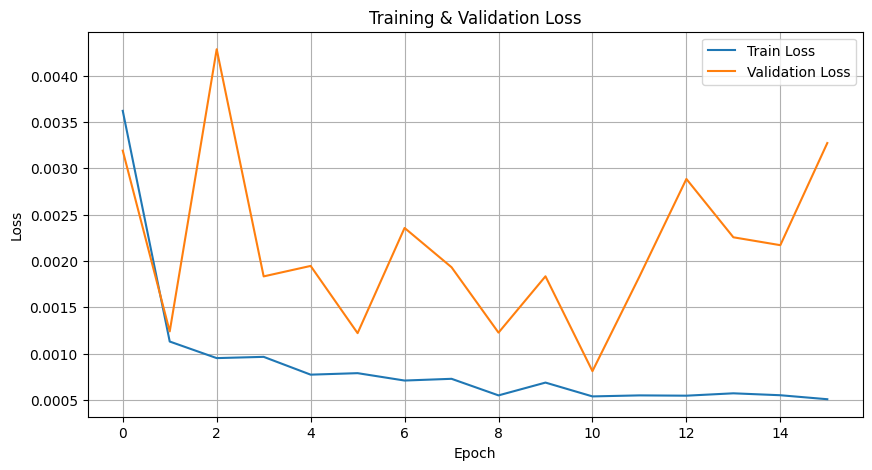

In [13]:
plot_training_loss(history)


## Step 7: Fine-Tune Model on Recent Data (Optional)
Use latest data to adapt the model before prediction.


In [14]:
# Fine-tune on latest data slice
X_recent, y_recent = X[-100:], y[-100:]
fine_tune_model("models/final_lstm_model.h5", X_recent, y_recent)


INFO:bitcoin_utils:Fine-tuning model at models/final_lstm_model.h5 on recent data...


Epoch 1/5
4/4 [==============================] - 1s 36ms/step - loss: 0.0255
Epoch 2/5
4/4 [==============================] - 0s 39ms/step - loss: 0.0179
Epoch 3/5
4/4 [==============================] - 0s 32ms/step - loss: 0.0154
Epoch 4/5
4/4 [==============================] - 0s 38ms/step - loss: 0.0089
Epoch 5/5
4/4 [==============================] - 0s 30ms/step - loss: 0.0107


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:bitcoin_utils: Model fine-tuned and saved.


## Step 8: Predict Next Price and Plot

We use the most recent input sequence and call `predict_next_price()` from the utility file.


INFO:bitcoin_utils:Predicting next Bitcoin price using latest sequence...


1/1 [==============================] - 0s 316ms/step


INFO:bitcoin_utils:Plotting recent prices with prediction...


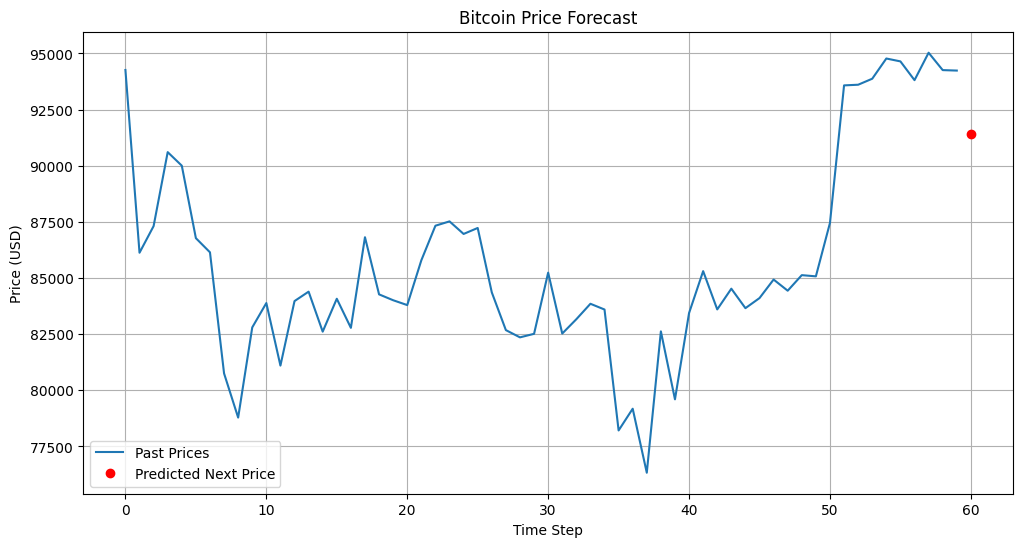

INFO:bitcoin_utils:Predicted price: $91,412.81


📈 Predicted Next Price: $91,412.81


In [15]:
from bitcoin_utils import predict_next_price

# Prepare last input
X_input = X[-1:].copy()
recent_prices = df['price'].iloc[-60:].values

# Predict and plot
predicted_price = predict_next_price(model, X_input, scaler_y, recent_prices, plot=True)
print(f"📈 Predicted Next Price: ${predicted_price:,.2f}")

